### mRNA Volcano Plots

This notebook serves to generate volcano plots for mRNA gene expression analysis.

In [1]:
# Get gene expression file
while True:
    total_expression_file_name: str = input("Provide gene expression data file (in the CSV format): ")

    if total_expression_file_name:
        break

if total_expression_file_name.endswith(".csv") == False:
    total_expression_file_name = f"{total_expression_file_name}.csv"

In [2]:
# Get fold change column name
fold_change_column_name_file: str = "fold"
user_input: str = input("Provide fold change column name (default: 'fold'): ")

if user_input:
    fold_change_column_name_file = user_input

In [3]:
# Get p-value column name
p_value_expression_column_name_file: str = "pvalue"
user_input: str = input("Provide p-value column name (default: 'pvalue'): ")

if user_input:
    p_value_expression_column_name_file = user_input

In [4]:
# Get gene name column name
gene_name_column_name_file: str = "GeneSymbol"
user_input: str = input("Provide gene name column name (default: 'GeneSymbol'): ")

if user_input:
    gene_name_column_name_file = user_input

In [5]:
# Get significant gene expression file
while True:
    significant_expression_file_name: str = input("Provide significant gene expression data file (in the CSV format): ")

    if significant_expression_file_name:
        break

if significant_expression_file_name.endswith(".csv") == False:
    significant_expression_file_name = f"{significant_expression_file_name}.csv"

In [6]:
# Get unique record identifier column name
record_id_column_name: str = "ProbeName"
user_input: str = input("Provide unique record identifier column name (default: 'ProbeName'): ")

if user_input:
    record_id_column_name = user_input

In [7]:
# Get p-value threshold
p_value_threshold: float = 0.05
user_input: str = input("Provide p-value threshold (default: 0.05): ")

if user_input:
    try:
        p_value_threshold = float(user_input)
    except:
        pass

In [8]:
# Get the top most changed gene count
top_fc_gene_count: int = 10
user_input: str = input("Provide top most changed (FC) gene count (default: 10): ")

if user_input:
    try:
        top_fc_gene_count = int(user_input)
    except:
        pass

In [9]:
# Get the plot title
plot_title: str = ""

for i in range(3):
    user_input: str = input(f"Provide plot title row {i}: ")

    if user_input:
        plot_title += f"{user_input}"

        if (i < 2):
            plot_title += "\n"


In [10]:
def clean_data(file_name: str) -> str:
    total_expression_data: list = []

    # Remove potential artifacts from Excel export
    with open(file_name, "r") as expression_file:
        rows = expression_file.readlines()

        for row in rows:
            stripped_row = row.rstrip(",,,\n")
            stripped_row = f"{stripped_row}\n"
            total_expression_data.append(stripped_row)

    # Save cleaned data to a new file to avoid overwriting the original
    cleaned_file_name = file_name.replace(".csv", "_cleaned.csv")

    with open(cleaned_file_name, "w") as cleaned_file:
        cleaned_file.writelines(total_expression_data)

    return cleaned_file_name

In [11]:
import pandas as pd

def get_color(total_df: pd.DataFrame, significant_df: pd.DataFrame,
              record_id: str, record_id_column_name: str,
              p_value_column_name: str, p_value_threshold: float,
              significant_correction_label: str, significant_label: str, non_significant_label: str) -> str:
    
    if record_id in significant_df[record_id_column_name].values:
        return significant_correction_label
    
    p_value: float = total_df.loc[total_df[record_id_column_name] == record_id, p_value_column_name].values[0]
    return significant_label if p_value < p_value_threshold else non_significant_label

In [12]:
# Read and process gene expression data
import math
import pandas as pd

cleaned_total_file_name: str = clean_data(total_expression_file_name)
cleaned_significant_file_name: str = clean_data(significant_expression_file_name)

fold_change_column_name: str = "log2(fold change)"
p_value_column_name: str = "p-value"

x_log_fold_change: list = []
y_log_p_value: list = []

total_df: pd.DataFrame = pd.read_csv(cleaned_total_file_name)
significant_df: pd.DataFrame = pd.read_csv(cleaned_significant_file_name)

# Drop rows with missing gene names BEFORE processing
total_df = total_df[total_df[gene_name_column_name_file].notna() & (total_df[gene_name_column_name_file] != '')]
total_df = total_df.reset_index(drop=True)

for index, row in total_df.iterrows():
    
    raw_fold_change = float(row[fold_change_column_name_file])
    log_fold_change: float = math.log2(raw_fold_change) if raw_fold_change > 0 else -math.log2(-raw_fold_change)
    x_log_fold_change.append(log_fold_change)

    raw_p_value = float(row[p_value_expression_column_name_file])
    log_p_value: float = -1 * math.log10(raw_p_value)
    y_log_p_value.append(log_p_value)

# Add calculated values as columns to the dataframe
total_df[fold_change_column_name] = x_log_fold_change
total_df[p_value_column_name] = y_log_p_value

# Add color column based on pathway significance
significance_column_name: str = "Legend"
significant_correction_label: str = "Significant (FDR-corrected)"
significant_label: str = "Significant"
non_significant_label: str = "Non-significant"

total_df[significance_column_name] = total_df[record_id_column_name].apply(
    lambda record_id: get_color(total_df, significant_df,
                                record_id, record_id_column_name,
                                p_value_expression_column_name_file, p_value_threshold,
                                significant_correction_label, significant_label, non_significant_label))

significant_from_total_df = total_df[total_df[record_id_column_name].isin(significant_df[record_id_column_name])]

Text(0.5, 1.0, 't\nt\nt')

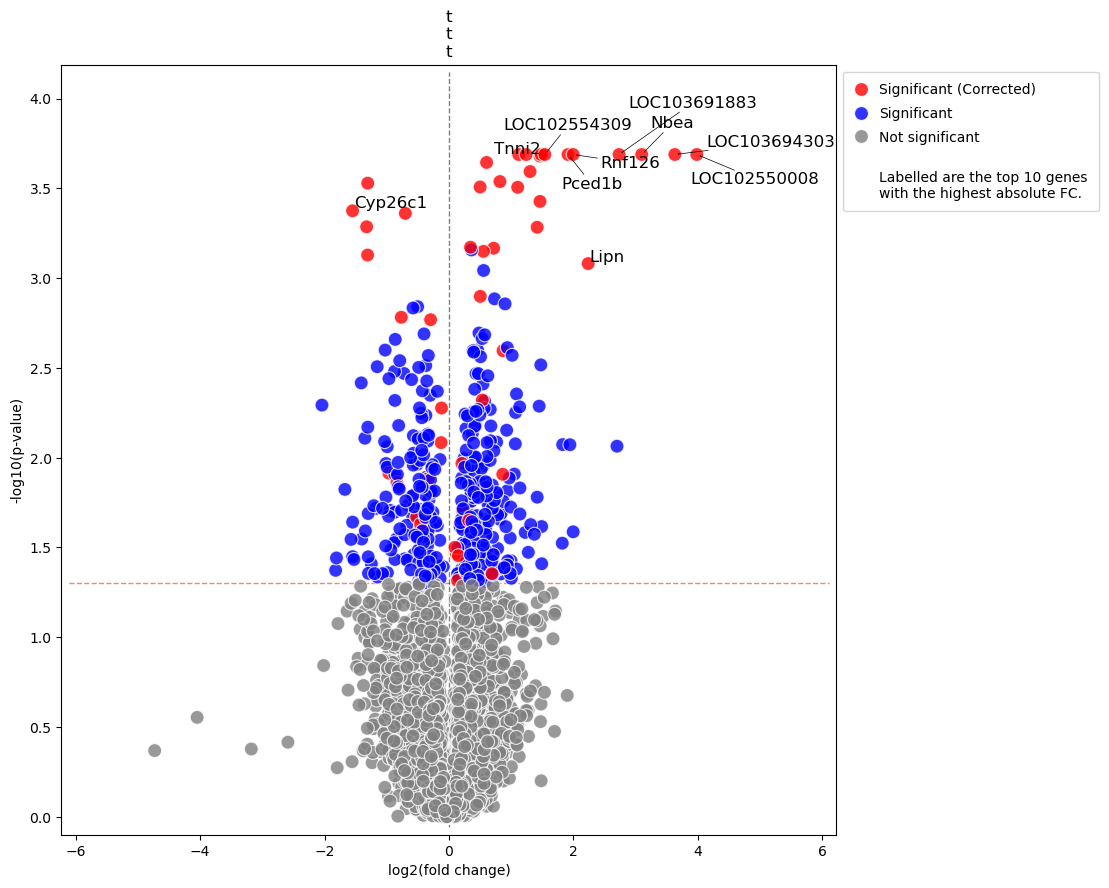

In [52]:
# Create volcano plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import adjustText

from matplotlib.lines import Line2D

plt.figure(figsize=(10, 10))
sns.scatterplot(data=total_df, x=fold_change_column_name, y=p_value_column_name,
                color='gray', alpha=0.8,
                hue=significance_column_name,
                hue_order=[significant_correction_label, significant_label, non_significant_label],
                palette=['red', 'blue', 'gray'],
                s=100)
plt.xlabel('log2(fold change)')
plt.ylabel('-log10(p-value)')
plt.axhline(y=-np.log10(0.05), zorder=0, xmin=0.01, xmax=0.99, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(x=0, zorder=0, ymin=0.01, ymax=0.99, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Set symmetric x-axis limits so 0 is in the center
max_abs_x = max(abs(total_df[fold_change_column_name].min()), abs(total_df[fold_change_column_name].max()))
x_margin = 1.5
plt.xlim(-max_abs_x - x_margin, max_abs_x + x_margin)

# Uncomment for vertical margins
y_margin_top = 0.5
y_margin_bottom = 0.1
plt.ylim(total_df[p_value_column_name].min() - y_margin_bottom, total_df[p_value_column_name].max() + y_margin_top)

labeled_fc_genes: list = []

top_fc_indexes = significant_from_total_df[fold_change_column_name].abs().nlargest(top_fc_gene_count).index
df_top_fc_genes = significant_from_total_df.loc[top_fc_indexes]

for _, row in df_top_fc_genes.iterrows():
    labeled_fc_genes.append(plt.text(x=row[fold_change_column_name],
                         y=row[p_value_column_name],
                         s=row[gene_name_column_name_file],
                         fontsize=12))

adjustText.adjust_text(labeled_fc_genes, force_text=(6.0,12.5), arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Customize legend with bold titles
# legend = plt.legend(loc=1, bbox_to_anchor=(1.35, 1), frameon=False)
# for text in legend.get_texts():
#     if text.get_text() in [pathway_significance_column_name, pathway_count_column_name]:
#         text.set_fontweight('bold')

# Extra description under the legend
additional_info = (
    f"\nLabelled are the top {top_fc_gene_count} genes\nwith the highest absolute FC."
)
# plt.gcf().text(0.92, 0.8, additional_info, ha="left", va="top", fontsize=10)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

extra_text_handle = Line2D([], [], linestyle="none", marker=None)

legend = ax.legend(
    handles + [extra_text_handle],
    labels + [additional_info],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=True,
    handlelength=1.0,
    labelspacing=0.7,
    borderpad=0.8
)

# Hide the symbol for the extra text row so it looks like plain legend text
legend.legend_handles[-1].set_visible(False)

plt.title(plot_title)
